# **Here are the instructions on how to access the dataset and run the project:**


*   Open your web browser and go to the following link: https://drive.google.com/drive/folders/1qsdQL7x77HU8x_zukJtwM0FbSL8-B35e?usp=sharing
*   In the Google Drive folder, you will find the dataset required for the project.
*   Click on the arrow next to the folder's name to reveal a dropdown menu.
*   From the dropdown menu, click on "Organize."
*   In the "Organize" menu, select "Add shortcut"
*   A window will pop up. Click on the "All locations" tab.
*   Select "My Drive" from the list of locations.
*   Click the "Add" button at the bottom of the window.

This action will create a shortcut to the dataset folder in your Google Drive.

Navigate to "My Drive" in your Google Drive. You should see the shortcut to the dataset folder.

Once you have added the shortcut to "My Drive," you are ready to run the project.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

    # Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Mounted at /content/drive
Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#Import libraries that needs to train the neural network
import numpy as np
import pandas as pd
import os
import re
import cv2
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image, ImageFile, ImageDraw


In [ ]:
#Dataset of the Simpsons Characters
base_path =  '/content/drive/My Drive/Final_Project/'
dataset_path = base_path + 'Dataset/'
simpsons_dataset_path = base_path + 'Dataset/simpsons_dataset'

Classification

In [ ]:
#constants
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS   = 3
EPOCHS = 10
FILE_PATH  = dataset_path

In [ ]:
# Load the dataset using TensorFlow
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 21979 files belonging to 2 classes.


In [ ]:
# Display class names in the dataset
class_names = dataset.class_names
class_names

['simpson_testset', 'simpsons_dataset']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 128, 128, 3)
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


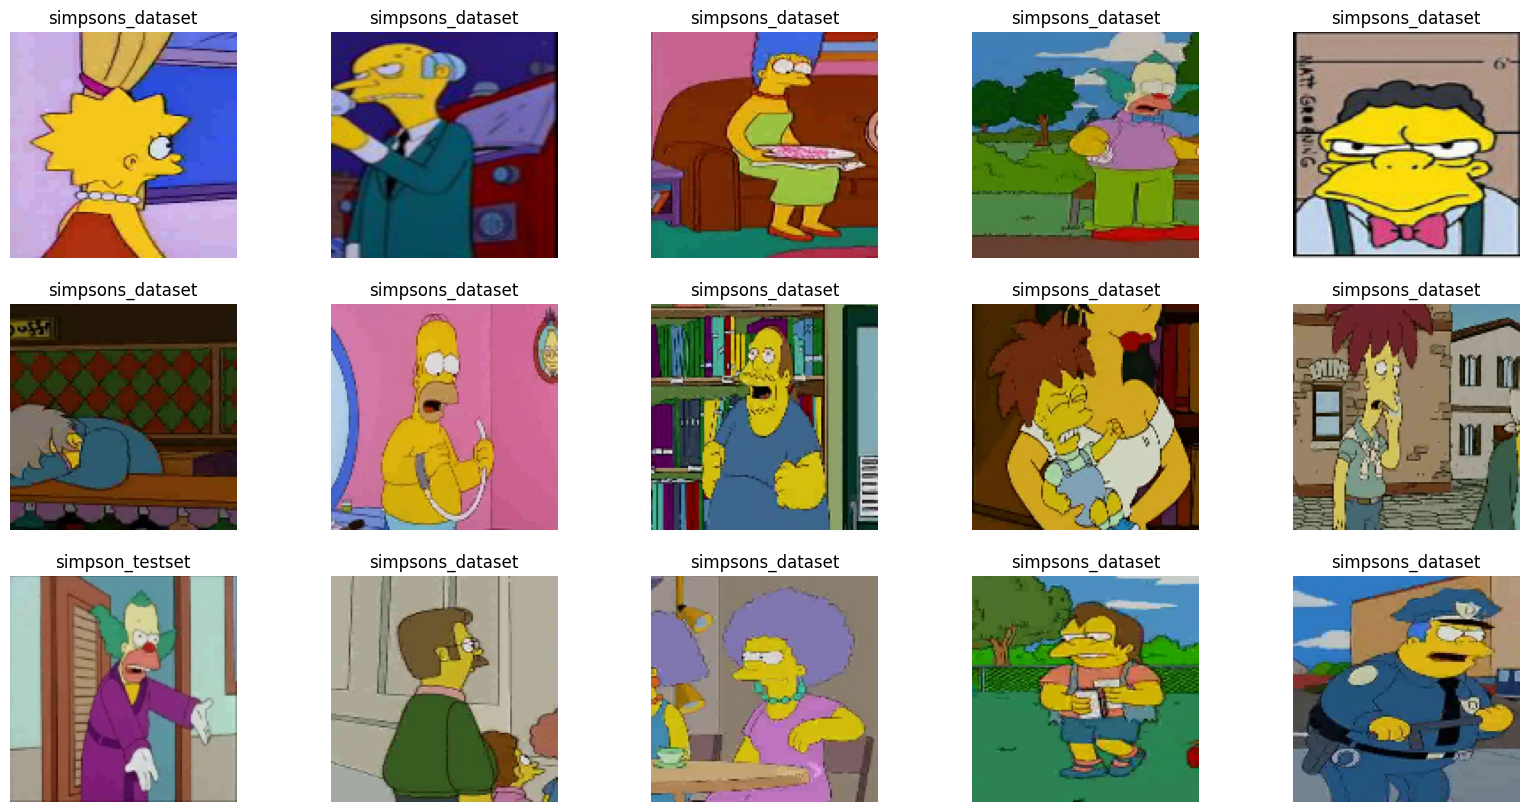

In [ ]:
# Display some images with the labels
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
# Function to partition the dataset into training, testing, and validation sets
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds ,test_ds, valid_ds

train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [ ]:
# Performance improving by both using caching and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Image Preprocessing : Rescaling and Resizing
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
# Model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    rescale_and_resize,
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [ ]:
model.build(input_shape=input_shape)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
# Label conversion function for character detection tasks
def convert_labels(annotation_data):
    converted_labels = []
    for entry in annotation_data:
        filepath, x1, y1, x2, y2, character = entry.split(',')
        x_center = (float(x1) + float(x2)) / 2
        y_center = (float(y1) + float(y2)) / 2
        width = float(x2) - float(x1)
        height = float(y2) - float(y1)
        converted_label = [character, x_center, y_center, width, height]
        converted_labels.append(converted_label)
    return converted_labels

# Load annotation data from your file
# Get access to the annotation labels from the dataset
converted_labels_path = base_path + '/annotation.txt'

# Read and print the content of the annotation file
with open(converted_labels_path, 'r') as file:
    annotation_data = file.read().splitlines()

# Convert your annotation data to labels
converted_labels = convert_labels(annotation_data)

# Output of converted labels
print(converted_labels)


[['abraham_grampa_simpson', 54.5, 72.0, -5.0, 0.0], ['abraham_grampa_simpson', 208.5, 192.5, 257.0, 323.0], ['abraham_grampa_simpson', 206.5, 227.5, 157.0, 359.0], ['abraham_grampa_simpson', 115.0, 200.5, 86.0, 149.0], ['abraham_grampa_simpson', 208.5, 238.5, 171.0, 355.0], ['abraham_grampa_simpson', 306.5, 215.5, 383.0, 395.0], ['abraham_grampa_simpson', 297.0, 230.0, 252.0, 366.0], ['abraham_grampa_simpson', 250.5, 231.0, 261.0, 356.0], ['abraham_grampa_simpson', 273.5, 231.0, 249.0, 350.0], ['abraham_grampa_simpson', 337.5, 248.5, 265.0, 415.0], ['abraham_grampa_simpson', 168.0, 226.5, 194.0, 395.0], ['abraham_grampa_simpson', 89.0, 216.0, 174.0, 384.0], ['abraham_grampa_simpson', 186.0, 256.0, 108.0, 180.0], ['abraham_grampa_simpson', 239.5, 221.0, 357.0, 366.0], ['abraham_grampa_simpson', 305.5, 260.0, 323.0, 428.0], ['abraham_grampa_simpson', 270.5, 223.5, 293.0, 353.0], ['abraham_grampa_simpson', 380.0, 300.0, 232.0, 342.0], ['abraham_grampa_simpson', 89.5, 237.5, 167.0, 457.0],

In [ ]:
# output layer for 4-class classification using TensorFlow
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
def map_function(x, y):
    # Ensure there is a return statement for all cases
    y_onehot = tf.one_hot(y, depth=n_classes)
    return x, y_onehot


In [ ]:
from tensorflow.keras.utils import to_categorical

# Assuming 'labels' is your original label data
labels = ['simpson_testset', 'simpsons_dataset', 'simpson_testset', 'simpsons_dataset']

# Convert class labels to numerical values
class_mapping = {'simpson_testset': 0, 'simpsons_dataset': 1}
numeric_labels = [class_mapping[label] for label in labels]

# Perform one-hot encoding
one_hot_labels = to_categorical(numeric_labels, num_classes=2)

# Print the result
print(one_hot_labels)



[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
train_ds_with_labels = train_ds.map(map_function)
valid_ds_with_labels = valid_ds.map(map_function)


Training

In [ ]:
# Define your learning rate schedule function
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Assuming n_classes is the number of classes in your classification task
n_classes = 2  # Since you have 2 classes: 'simpson_testset' and 'simpsons_dataset'

# Define your model
model = models.Sequential([
    rescale_and_resize,
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Make sure the number of units matches the number of classes
])

# Build the model
model.build(input_shape=input_shape)

# Compile the model with the SGD optimizer and sparse_categorical_crossentropy loss
sgd_optimizer = SGD(learning_rate=0.01)
model.compile(optimizer=sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)

# Train the model with the learning rate scheduler callback
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[lr_scheduler]
)


Epoch 1/10
549/549 [==============================] - 3180s 2s/step - loss: 0.1847 - accuracy: 0.9537 - val_loss: 0.1900 - val_accuracy: 0.9494 - lr: 0.0100
Epoch 2/10
549/549 [==============================] - 483s 880ms/step - loss: 0.1762 - accuracy: 0.9554 - val_loss: 0.1895 - val_accuracy: 0.9494 - lr: 0.0100
Epoch 3/10
549/549 [==============================] - 487s 887ms/step - loss: 0.1736 - accuracy: 0.9554 - val_loss: 0.1840 - val_accuracy: 0.9494 - lr: 0.0100
Epoch 4/10
549/549 [==============================] - 488s 889ms/step - loss: 0.1705 - accuracy: 0.9554 - val_loss: 0.1764 - val_accuracy: 0.9494 - lr: 0.0100
Epoch 5/10
549/549 [==============================] - 483s 880ms/step - loss: 0.1674 - accuracy: 0.9554 - val_loss: 0.1764 - val_accuracy: 0.9494 - lr: 0.0100
Epoch 6/10
549/549 [==============================] - 481s 875ms/step - loss: 0.1637 - accuracy: 0.9554 - val_loss: 0.1639 - val_accuracy: 0.9494 - lr: 0.0100
Epoch 7/10
549/549 [============================

In [ ]:
# Save the trained model for future use and stored in 'model' variable
model.save('/content/drive/My Drive/Final_Project/face_recognition_model1.keras')

In [ ]:
# Load the model that was already trained
model = tf.keras.models.load_model('/content/drive/My Drive/Final_Project/face_recognition_model1.keras')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

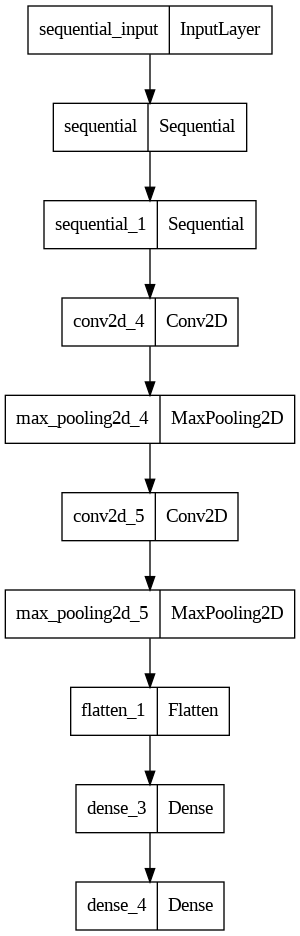

In [ ]:
#plotting the model architechture
plot_model(model)

In [ ]:
scores = model.evaluate(test_ds)
scores

70/70 [==============================] - 317s 219ms/step - loss: 0.1535 - accuracy: 0.9548


[0.15351544320583344, 0.954809844493866]

In [ ]:
history.history['accuracy']

[0.9537226557731628,
 0.9554303288459778,
 0.9554303288459778,
 0.9554303288459778,
 0.9554303288459778,
 0.9554303288459778,
 0.9554303288459778,
 0.9554303288459778,
 0.9554303288459778,
 0.9554303288459778]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

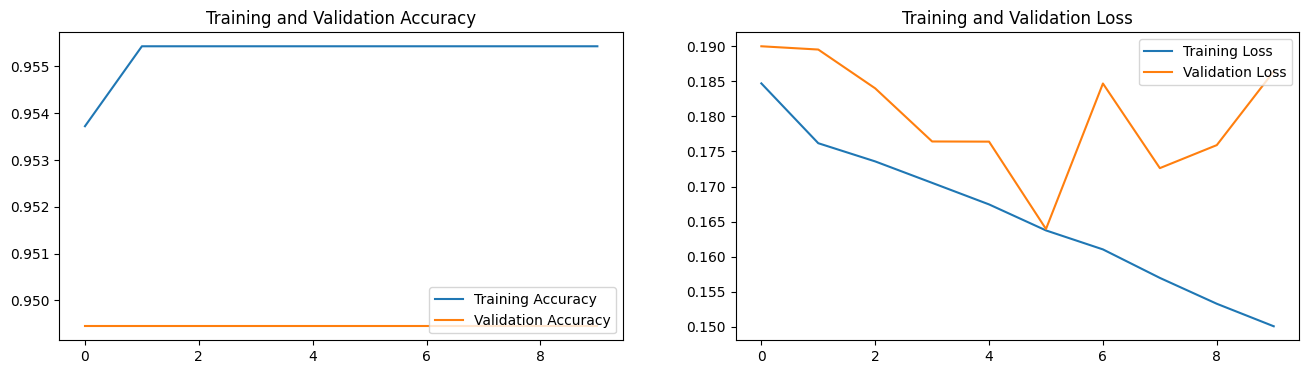

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: simpsons_dataset
1/1 [==============================] - 0s 344ms/step
predicted label: simpsons_dataset


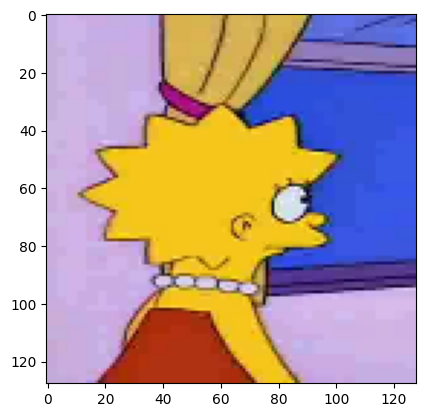

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Image Detection


In [ ]:
# Load a pre-trained object detection model from TensorFlow Hub
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
detector = hub.load(model_url)

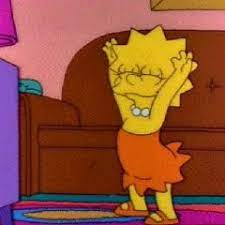

In [ ]:
# Path to the image of the character you want to find
find_character_path = base_path + '/Find_character/person_3.jpg'
img_person = Image.open(find_character_path)
img_person

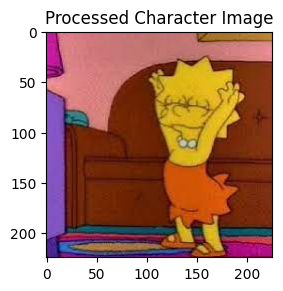

In [ ]:
# Load and preprocess the image
img_character = Image.open(find_character_path)
img_array_character = np.array(img_character)
converted_img_character = tf.image.convert_image_dtype(img_array_character, dtype=tf.uint8)[tf.newaxis, ...]

# Display the processed image
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(converted_img_character))
plt.title('Processed Character Image')
plt.show()

In [ ]:
# Make predictions for the character image
result_character = detector(converted_img_character)

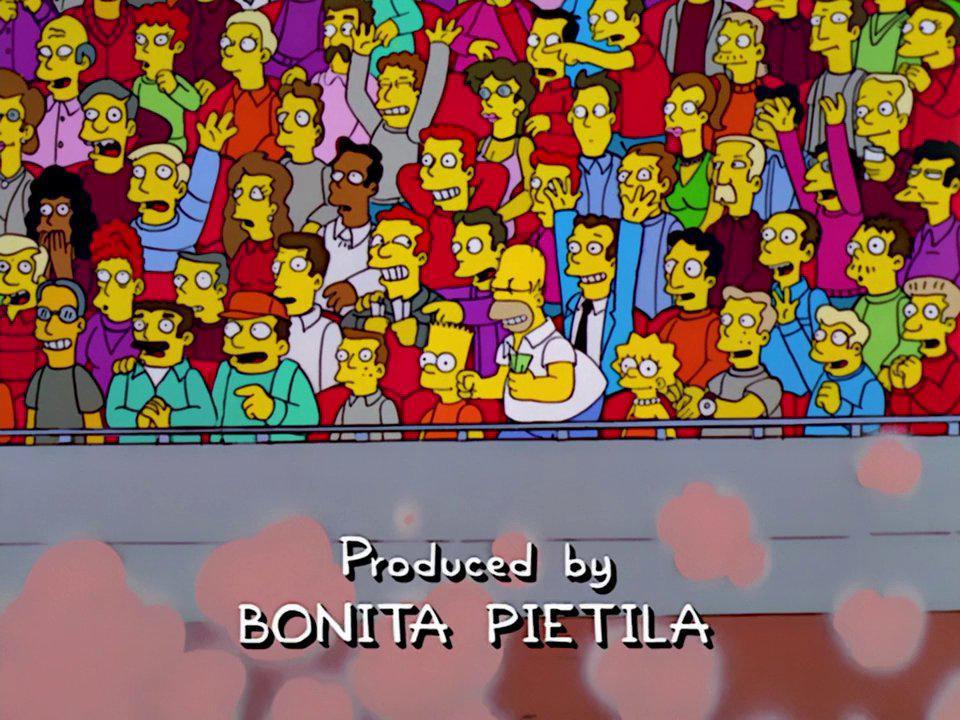

In [ ]:
#Path to the crowded area where you want to find that character
crowded_im_path= base_path + '/crowded_areas/b_2.jpg'
crowded_im = Image.open(crowded_im_path)
crowded_im

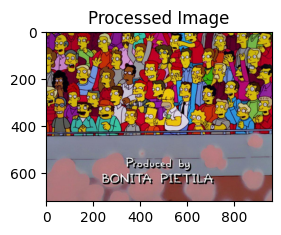

In [ ]:
# Load and preprocess the crowded room image
img_crowded_area = cv2.imread(crowded_im_path)
img_crowded_area_rgb = cv2.cvtColor(img_crowded_area, cv2.COLOR_BGR2RGB)
converted_img_crowded_area = tf.image.convert_image_dtype(img_crowded_area_rgb, dtype=tf.uint8)[tf.newaxis, ...]

# Display the processed image
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(converted_img_crowded_area))
plt.title('Processed Image')
plt.show()

In [ ]:
# Make predictions for the crowded room image
result_crowded_area = detector(converted_img_crowded_area)

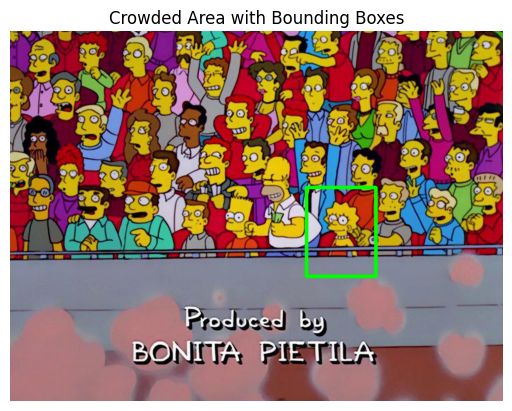

In [ ]:
# Get the bounding box coordinates for the character in the crowded room
new_character_bbox = result_character['detection_boxes'].numpy()[0]
target_label = 'lisa_simpson'  # Assuming 'person' is the label for the character
# Iterate through each bounding box
for box in new_character_bbox:
    y_min, x_min, y_max, x_max = box
 # Calculate the center of the bounding box
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2

    # Scale down the bounding box
    scale_factor = 0.3
    width = (x_max - x_min) * scale_factor
    height = (y_max - y_min) * scale_factor

    # Adjust the bounding box coordinates based on the scaled width and height
    new_x_min = center_x - width / 2
    new_x_max = center_x + width / 2
    new_y_min = center_y - height / 2
    new_y_max = center_y + height / 2

    # Draw the bounding box on the crowded room image
    img_crowded_area_with_box = img_crowded_area_rgb.copy()
    cv2.rectangle(img_crowded_area_with_box,
                      (int(new_x_min * img_crowded_area.shape[1]), int(new_y_min * img_crowded_area.shape[0])),
                      (int(new_x_max * img_crowded_area.shape[1]), int(new_y_max * img_crowded_area.shape[0])), (0, 255, 0), 5)
    # Display the crowded room image with all bounding boxes
plt.imshow(img_crowded_area_with_box)
plt.axis('off')
plt.title('Crowded Area with Bounding Boxes')
plt.show()